# Análise de Vendas de Suplementos
# Autor: Julia Monteiro
# Base de dados: https://www.kaggle.com/datasets/zahidmughal2343/supplement-sales-data

# Análise exploratória de dados

In [2]:
# 0. Importando as bibliotecas
import numpy as np 
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX

import torch 
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler, Dataset, DataLoader 
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error, mean_absolute_error
import os


from tqdm.notebook import tqdm

In [3]:
# 1. Leia o arquivo CSV 
df = pd.read_csv(r"C:\Users\Acer\Downloads\Supplement_Sales_Weekly_Expanded.csv", encoding='cp1252', sep=';')

In [4]:
# 2. Exibindo a tabela
df.head()

,Date,Product Name,Category,Units Sold,Price,Revenue,Discount,Units Returned,Location,Platform
0,06/01/2020,Whey Protein,Protein,143,31.98,4573.14,0.03,2,Canada,Walmart
1,06/01/2020,Vitamin C,Vitamin,139,42.51,5908.89,0.04,0,UK,Amazon
2,06/01/2020,Fish Oil,Omega,161,12.91,2078.51,0.25,0,Canada,Amazon
3,06/01/2020,Multivitamin,Vitamin,140,16.07,2249.80,0.08,0,Canada,Walmart
4,06/01/2020,Pre-Workout,Performance,157,35.47,5568.79,0.25,3,Canada,iHerb


In [5]:
# 3. Exibindo as informações
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4384 entries, 0 to 4383
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            4384 non-null   object 
 1   Product Name    4384 non-null   object 
 2   Category        4384 non-null   object 
 3   Units Sold      4384 non-null   int64  
 4   Price           4384 non-null   float64
 5   Revenue         4384 non-null   float64
 6   Discount        4384 non-null   float64
 7   Units Returned  4384 non-null   int64  
 8   Location        4384 non-null   object 
 9   Platform        4384 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 342.6+ KB
None


A partir dessas informações podemos concluir que:
- Nessa base de dados têm 4384 linhas, numeradas de 0 a 4383, e 10 colunas;
- Não existem dados faltantes;
- Os tipos de dados são: object (texto ou data no formato de texto), int64 (número inteiro) e float64 (número decimal).

In [6]:
# 4. Exibindo estatíscas básicas
print(df.describe())

        Units Sold        Price       Revenue     Discount  Units Returned
count  4384.000000  4384.000000   4384.000000  4384.000000     4384.000000
mean    150.200274    34.781229   5226.569446     0.124398        1.531478
std      12.396099    14.198309   2192.491946     0.071792        1.258479
min     103.000000    10.000000   1284.000000     0.000000        0.000000
25%     142.000000    22.597500   3349.372500     0.060000        1.000000
50%     150.000000    34.720000   5173.140000     0.120000        1.000000
75%     158.000000    46.712500   7009.960000     0.190000        2.000000
max     194.000000    59.970000  10761.850000     0.250000        8.000000


Resumo da análise estatística: 
- As colunas analisadas foram: Units Sold (Unidades vendidas), Price (Preço por unidade), Revenue (Receita= Price × Units Sold), Discount (Desconto) e Units Returned (Unidades devolvidas);

- Interpretação dos dados:
   -Units Sold (Unidades Vendidas):
       Média: 150 unidades
       Variação pequena: de 103 a 194 (desvio padrão de aproximadamente 12)
       A maioria das vendas está entre 142 e 158 unidades (25% e 75%)

    -Price (Preço unitário)
       Média: 34,78
       Variação alta: de 10.00 a 59.97
       Metade dos preços está entre 22.60 e 46.71

    -Revenue (Receita total)
       Média: 5226.57
       Variação alta: de 1284.00 a 10761.85 (desvio padrão alto de 2192,49)
       A maioria das receitas está entre 3349.37 e 7009.96

    -Discount (Desconto)
       Média: 12,4%
       Varia entre 0% e 25%
       Metade das vendas tem desconto de até 12%

    -Units Returned (Devoluções)
        Média: 1,5 unidade devolvida
        Varia de 0 a 8 devoluções
        A maioria dos registros tem 1 ou 2 devoluções

De forma resumida, é possível analisar que:

- O número de unidades vendidas é sólido;

- O preço não tem uma variação exorbitante e sim moderada;

- A receita acompanha a variação de preço e vendas;

- Os descontos são aplicados em graus variados, mas não ultrapassando 25%;

- Em média as devoluções são baixas.        


In [7]:
# 5. Exibindo quais informações estão disponiveis na base de dados
print('Os dados categoricos são:')
print('Tipo de suplemento:', df["Category"].unique())
print('Localização:', df["Location"].unique())
print('Local de venda:', df["Platform"].unique())

Os dados categoricos são:
Tipo de suplemento: ['Protein' 'Vitamin' 'Omega' 'Performance' 'Amino Acid' 'Mineral' 'Herbal'
 'Sleep Aid' 'Fat Burner' 'Hydration']
Localização: ['Canada' 'UK' 'USA']
Local de venda: ['Walmart' 'Amazon' 'iHerb']


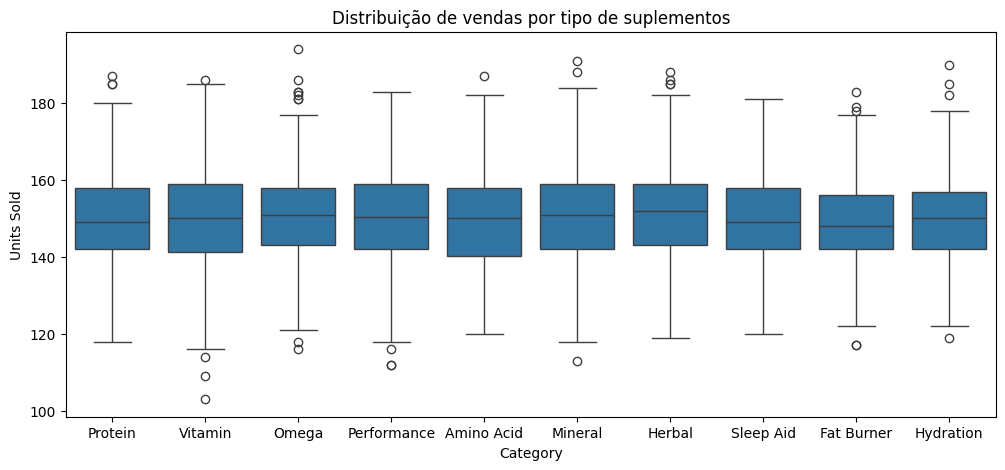

In [8]:
plt.figure(figsize=(12,5))
sns.boxplot(x="Category",y="Units Sold",data=df)
plt.title("Distribuição de vendas por tipo de suplementos")
plt.show()

Através do boxplot podemos tirar as seguintes conclusões: 
- A mediana das vendas é parecida entre as categorias, de aproximadamente 150 unidsdes, o que sugere uma uniformidade nas vendas dos suplementos.

- Todas as categorias apresentam outliers, ou seja, em algumas semanas as vendas foram maiores ou menores do que o padrão apresentado entre as categorias.

- Como a largura e o comprimento dos boxplots não apresentam mudanças drasticas entre eles, isso sugere que não existe uma variação discrepante nas vendas entre as diferentes categorias.


De forma resumida, podemos observar que não há uma categoria superior ou inferior em vendas. E que algumas categorias, como Omega, Mineral e Herbal, têm mais outliers no topo, indicando possíveis picos ocasionais de vendas, enquando a categoria Vitamin apresenta alguns valores bem baixos, sinalizando semanas de baixo desempenho.

In [9]:
# 6. Extrair o ano
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df['Year'] = df['Date'].dt.year


In [10]:
# 7. Agrupar os dados por Year e Location somando as vendas
sales_per_year_location = df.groupby(['Year', 'Location'])['Units Sold'].sum().reset_index()


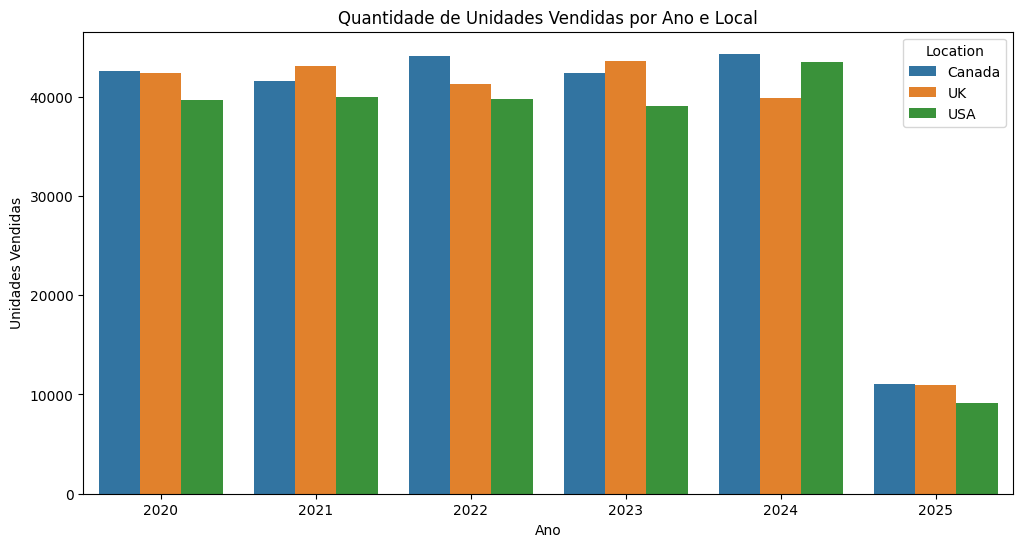

In [11]:
# 8. Gráfico para comparar quantas unidades foram vendidas em cada ano e local
plt.figure(figsize=(12,6))
sns.barplot(data=sales_per_year_location, x='Year', y='Units Sold', hue='Location')
plt.title('Quantidade de Unidades Vendidas por Ano e Local')
plt.xlabel('Ano')
plt.ylabel('Unidades Vendidas')
plt.show()


O gráfico acima apresenta a quantidade de unidades vendidas de suplementos entre Janeiro de 2020 à Abril de 2025, segmentadas por país (Canadá, Reino Unido e Estados Unidos). A partir dessa visualização é possível fazer algumas análises:

- Estabilidade nas Vendas (2020–2024):
Entre os anos de 2020 a 2024, as vendas mantiveram-se em altos níveis, com todos os países registrando volumes acima de 39.000 unidades anuais, sugerindo um mercado consolidado.

- Durante os anos de 2022 e 2024 o Canadá destacou-e como líder em vendas.

- O Reino Unido apresentou picos de venda em 2021 e 2023, o que pode indicar um investimento em campanhas de marketing.

- Os Estados Unidos apesar de manterem um nível ligeiramente inferior em relação aos demais, permaneceram estaveis com crescimento notável em 2024.

- Como os dados de 2025 estão incompletos, observa-se uma redução brusca nas vendas em todos os países. As unidades vendidas caem para cerca de 10000 unidades.

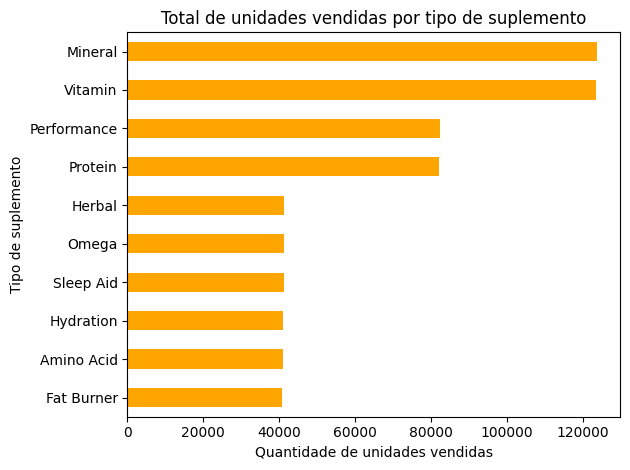

In [12]:
# 9. Gráfico para mostrar o total de unidades vendidas por tipo de suplemento
cat_sales = df.groupby('Category')['Units Sold'].sum().sort_values()
plt.figure()
cat_sales.plot(kind='barh', color='orange')
plt.title("Total de unidades vendidas por tipo de suplemento")
plt.xlabel("Quantidade de unidades vendidas")
plt.ylabel("Tipo de suplemento")
plt.tight_layout()
plt.show()

A visualização acima mostra o total de unidades vendidas por tipo de suplemento, e a partir dela é possível identificar uma concentração expressiva de vendas em quatro categorias principais, com os seguintes destaques:

- Os suplementos com maior volume de vendas são os minerais e as vitaminas, liderando com mais de 120.000 unidades vendidas cada, mostrando uma alta demanda por nutrientes essenciais e suplementação preventiva.

- Em seguida, com cerca de 80.000 unidades vendidas, vem os suplementos de performance e proteina, indicando uma forte presença de consumidores com foco em atividade física e ganho de massa muscular.

- Os suplementos com menos procura foram as categorias Herbal, Omega, Sleep Aid, Hydration, Amino Acid e Fat Burner, registrando um número de vendas bem inferior, em torno de 35.000 a 40.000 unidades cada. Isso pode indicar menor demanda, nichos mais específicos ou até menos investimento em marketing e distribuição para essas categorias.


Ou seja, a análise revela que os consumidores priorizam suplementos básicos e amplamente recomendados, como vitaminas e minerais, seguidos pelos relacionados ao desempenho físico. Enquanto que os suplementos voltados para funções específicas ou públicos mais restritos, como sono ou emagrecimento, têm menor aderância no mercado.

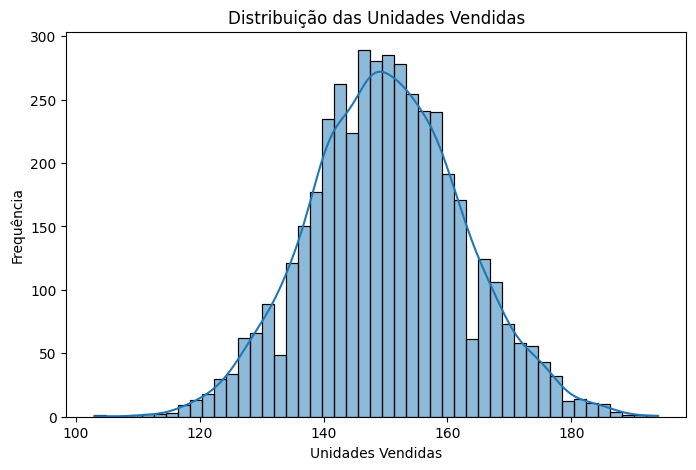

In [13]:
# Histograma das vendas (Unidades Vendidas)
plt.figure(figsize=(8,5))
sns.histplot(df['Units Sold'], kde=True)
plt.title('Distribuição das Unidades Vendidas')
plt.xlabel('Unidades Vendidas')
plt.ylabel('Frequência')
plt.show()

Observando o histograma é possível identificar que a curva é muito semelhante com a curva Gaussiana, o que mostra que a distribuição de vendas é quase simétrica, apresentando somente uma leve assimetria à direita. Além disso, a maior partes das observações está concentrada entre 135 e 165 unidades vendidas por registro.

Modelo de ML em construção...

# Criação de um modelo de ML para análise preditiva

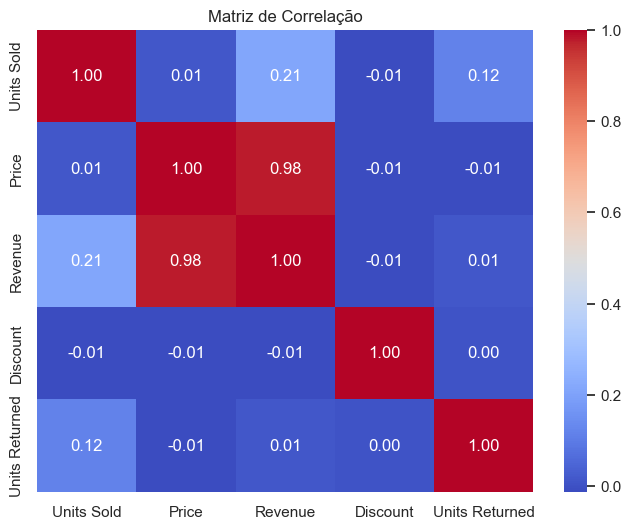

In [ ]:
# 11. Matriz correlação
numeric_data=df.select_dtypes(include=["float64","int64"])
correlation_matrix=numeric_data.corr()
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix,annot=True,cmap="coolwarm",fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

Pode-se oberservar a partir da matriz de correlação que o principal destaque foi a correlação positiva entre preço e receita, de 0.98, indicando que o preço dos produtos é o principal determinante da receita total. Enquanto, a correlação entre quantidade vendida e receita foi mais fraca, de 0.21, sugerindo que o volume de vendas tem um impacto relativamente menor. Isso mostra que os produtos com preços mais altos contribuíram de forma mais significativa para a geração de receita do que os produtos com maior volume de unidades vendidas.

Outro ponto relevante é que a variável desconto não apresentou correlação significativa com nenhuma das outras variáveis analisadas, indicando que os descontos oferecidos não tiveram impacto perceptível sobre o volume de vendas, a receita ou até mesmo a quantidade de devoluções. Esse resultado pode sinalizar que a estratégia de descontos pode estar mal direcionada, sendo aplicada a produtos com baixa atratividade ou comunicada de forma pouco eficaz ao consumidor.

A variável unidades devolvidas também apresentou correlação muito fraca com todas as outras variáveis. Isso sugere que as devoluções ocorrem de maneira quase aleatória, sem relação clara com os preços, descontos ou quantidade de produtos vendidos.

A partir desses pontos pode-se concluir que os produtos de maior valor devem continuar sendo priorizados, afinal têm maior impacto na receita. A políticas de descontos devem ser revisadas, novas abordagens devem ser testadas, visando o foco em produtos estratégicos ou períodos sazonais. E por fim, também faz-se necessário inesvtigar os motivos de devoluação, uma vez que eles não apresentam nenhuma relação com o preço ou volume e, além disso, essa prática pode ajudar a melhoras a experiência do cliente e reduzir as perdas.